In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../')))
from db_connection.connection import PostgresConnection

# Adjust the path to point to the src directory


In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../src')))

from utils import load_data, aggregate_engagement, normalize_data, kmeans_clustering, plot_elbow_method, compute_silhouette_score, plot_top_apps


# Set up database connection


In [3]:
db = PostgresConnection()
db.connect()

Connected to PostgreSQL Database!


# Load data from the database


In [4]:
query = "SELECT * FROM xdr_data;"
df = db.fetch_data(query)

c:\Users\habteyes.asfaw\10Accadamy\TellCo-Telecom-User-Analytics\db_connection\connection.py:29: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  return pd.read_sql_query(query, self.conn)


In [5]:
# Display the first few rows of the data
df.head()

,Bearer Id,Start,Start ms,End,End ms,Dur. (ms),IMSI,MSISDN/Number,IMEI,Last Location Name,...,Youtube DL (Bytes),Youtube UL (Bytes),Netflix DL (Bytes),Netflix UL (Bytes),Gaming DL (Bytes),Gaming UL (Bytes),Other DL (Bytes),Other UL (Bytes),Total UL (Bytes),Total DL (Bytes)
0,1.311448e+19,4/4/2019 12:01,770.0,4/25/2019 14:35,662.0,1823652.0,2.082014e+14,3.366496e+10,3.552121e+13,9.16456699548519E+015,...,15854611.0,2501332.0,8198936.0,9656251.0,278082303.0,14344150.0,171744450.0,8814393.0,36749741.0,308879636.0
1,1.311448e+19,4/9/2019 13:04,235.0,4/25/2019 8:15,606.0,1365104.0,2.082019e+14,3.368185e+10,3.579401e+13,L77566A,...,20247395.0,19111729.0,18338413.0,17227132.0,608750074.0,1170709.0,526904238.0,15055145.0,53800391.0,653384965.0
2,1.311448e+19,4/9/2019 17:42,1.0,4/25/2019 11:58,652.0,1361762.0,2.082003e+14,3.376063e+10,3.528151e+13,D42335A,...,19725661.0,14699576.0,17587794.0,6163408.0,229584621.0,395630.0,410692588.0,4215763.0,27883638.0,279807335.0
3,1.311448e+19,4/10/2019 0:31,486.0,4/25/2019 7:36,171.0,1321509.0,2.082014e+14,3.375034e+10,3.535661e+13,T21824A,...,21388122.0,15146643.0,13994646.0,1097942.0,799538153.0,10849722.0,749039933.0,12797283.0,43324218.0,846028530.0
4,1.311448e+19,4/12/2019 20:10,565.0,4/25/2019 10:40,954.0,1089009.0,2.082014e+14,3.369980e+10,3.540701e+13,D88865A,...,15259380.0,18962873.0,17124581.0,415218.0,527707248.0,3529801.0,550709500.0,13910322.0,38542814.0,569138589.0


## Aggregate Engagement Metrics


In [6]:
# Check for missing values
print(df[['MSISDN/Number', 'Bearer Id', 'Dur. (ms)', 'Total UL (Bytes)', 'Total DL (Bytes)']].isnull().sum())


MSISDN/Number       1066
Bearer Id            991
Dur. (ms)              1
Total UL (Bytes)       1
Total DL (Bytes)       1
dtype: int64


In [7]:
user_agg = aggregate_engagement(df)
print("Aggregated User Engagement Data")
display(user_agg.head())

Aggregated User Engagement Data


,MSISDN/Number,sessions_frequency,session_duration,total_traffic
0,3.360100e+10,1,116720.0,8.786906e+08
1,3.360100e+10,1,181230.0,1.568596e+08
2,3.360100e+10,1,134969.0,5.959665e+08
3,3.360101e+10,1,49878.0,4.223207e+08
4,3.360101e+10,2,37104.0,1.457411e+09


## Normalize engagement metrics for clustering

In [8]:
columns_to_normalize = ['sessions_frequency', 'session_duration', 'total_traffic']
normalized_data = normalize_data(user_agg, columns_to_normalize)
print("Normalized Data")
display(normalized_data.head())

Normalized Data


,scaled_sessions_frequency,scaled_session_duration,scaled_total_traffic
0,-0.481290,-0.158014,0.382297
1,-0.481290,0.188148,-1.087666
2,-0.481290,-0.060090,-0.193453
3,-0.481290,-0.516690,-0.547071
4,0.753493,-0.585235,1.560825


# Merge normalized data with user IDs


In [9]:
normalized_data['MSISDN/Number'] = user_agg['MSISDN/Number']


###  Determine the optimal number of clusters using the Elbow Method


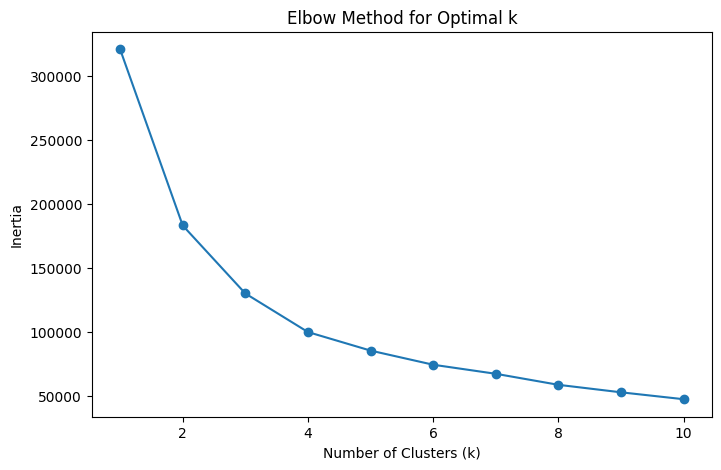

In [10]:
plot_elbow_method(normalized_data, [f'scaled_{col}' for col in columns_to_normalize])


 ## Apply K-Means clustering (with k=3)


In [11]:
kmeans_df, kmeans_model = kmeans_clustering(normalized_data, [f'scaled_{col}' for col in columns_to_normalize], n_clusters=3)


In [12]:
# Add cluster labels to the original aggregated data
user_agg['cluster'] = kmeans_df['cluster']

#  Compute summary statistics for each cluster



In [13]:
cluster_summary = user_agg.groupby('cluster').agg(
    num_users=('MSISDN/Number', 'count'),
    avg_sessions=('sessions_frequency', 'mean'),
    avg_duration=('session_duration', 'mean'),
    avg_traffic=('total_traffic', 'mean'),
    total_sessions=('sessions_frequency', 'sum'),
    total_duration=('session_duration', 'sum'),
    total_traffic=('total_traffic', 'sum')
).reset_index()
print("Cluster Summary Statistics")
display(cluster_summary)


Cluster Summary Statistics


,cluster,num_users,avg_sessions,avg_duration,avg_traffic,total_sessions,total_duration,total_traffic
0,0,3578,4.399944,656274.260481,2.286624e+09,15743,2.348149e+09,8.181541e+12
1,1,79818,1.022451,103063.468779,4.950560e+08,81610,8.226320e+09,3.951438e+13
2,2,23460,2.180435,215019.965942,1.114131e+09,51153,5.044368e+09,2.613752e+13


# Visualize the clusters


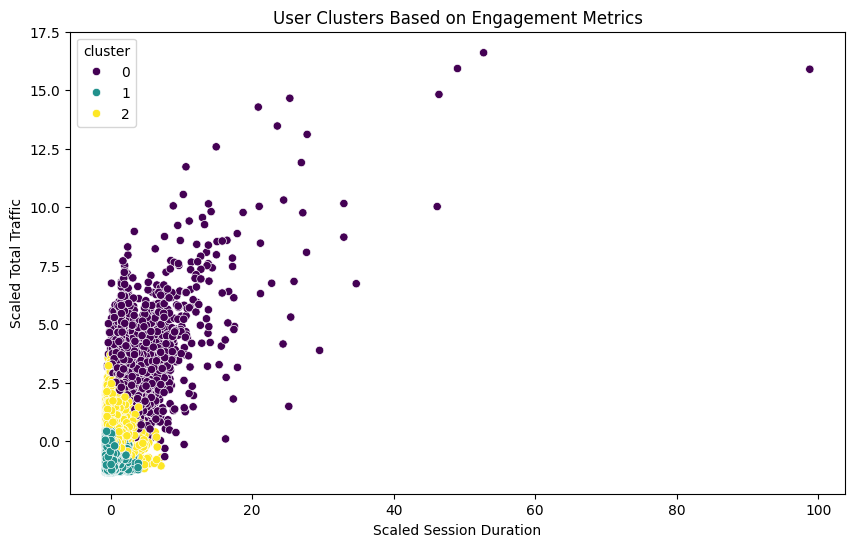

In [14]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=kmeans_df,
    x='scaled_session_duration',
    y='scaled_total_traffic',
    hue='cluster',
    palette='viridis'
)
plt.title('User Clusters Based on Engagement Metrics')
plt.xlabel('Scaled Session Duration')
plt.ylabel('Scaled Total Traffic')
plt.show()

## Aggregate user total traffic per application

In [15]:

app_usage = df.groupby('MSISDN/Number').agg({
    'Social Media DL (Bytes)': 'sum',
    'Google DL (Bytes)': 'sum',
    'Email DL (Bytes)': 'sum',
    'Youtube DL (Bytes)': 'sum',
    'Netflix DL (Bytes)': 'sum',
    'Gaming DL (Bytes)': 'sum',
    'Other DL (Bytes)': 'sum'
}).reset_index()


In [16]:
# Identify top 10 most engaged users per application
top_users_per_app = {}
applications = ['Social Media DL (Bytes)', 'Google DL (Bytes)', 'Email DL (Bytes)', 'Youtube DL (Bytes)', 'Netflix DL (Bytes)', 'Gaming DL (Bytes)', 'Other DL (Bytes)']

for app in applications:
    top_users = app_usage.nlargest(10, app)[['MSISDN/Number', app]]
    top_users_per_app[app] = top_users


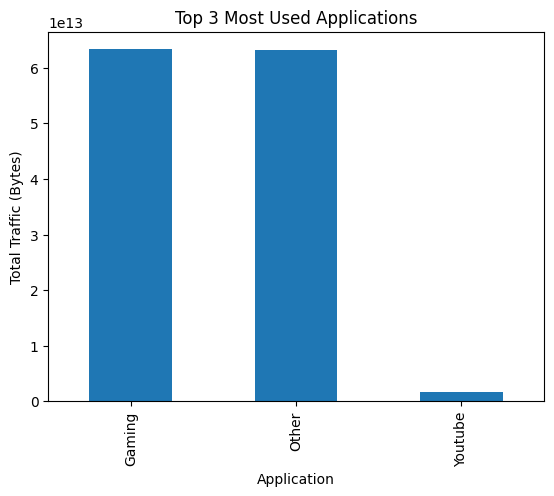

In [17]:
# Step 9: Plot the top 3 most used applications
plot_top_apps(df)